In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')
import matplotlib.pylab as plt
import calendar
import warnings
warnings.filterwarnings("ignore")


import datetime
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats

from sklearn.model_selection import GroupKFold
from typing import Any
from numba import jit
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics
from itertools import product
import copy
import time

import random
seed = 1234
random.seed(seed)
np.random.seed(seed)

In [4]:
train = pd.read_csv('../input/data-science-bowl-2019/train.csv')
train_labels = pd.read_csv('../input/data-science-bowl-2019/train_labels.csv')
test = pd.read_csv('../input/data-science-bowl-2019/test.csv')
specs = pd.read_csv('../input/data-science-bowl-2019/specs.csv')
sample_submission = pd.read_csv('../input/data-science-bowl-2019/sample_submission.csv')

In [5]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [6]:
train.shape

(11341042, 11)

In [7]:
train.columns

Index(['event_id', 'game_session', 'timestamp', 'event_data',
       'installation_id', 'event_count', 'event_code', 'game_time', 'title',
       'type', 'world'],
      dtype='object')

'''Kaggle provided the following note: Note that the training set contains many installation_ids which never took assessments, whereas every installation_id in the test set made an attempt on at least one assessment.'''

Deleting 'installation_id' which are not "Assessment"

In [14]:
# Select all Assessment from installation_id
keep_id = train[train["type"] == "Assessment"]["installation_id"].drop_duplicates()

train = pd.merge(train, keep_id, on="installation_id", how="inner")

In [15]:
train.shape

(8294138, 11)

In [10]:
keep_id.shape

(4242,)

In [11]:
train.type.value_counts()

Game          4125872
Activity      3139703
Assessment     925345
Clip           103218
Name: type, dtype: int64

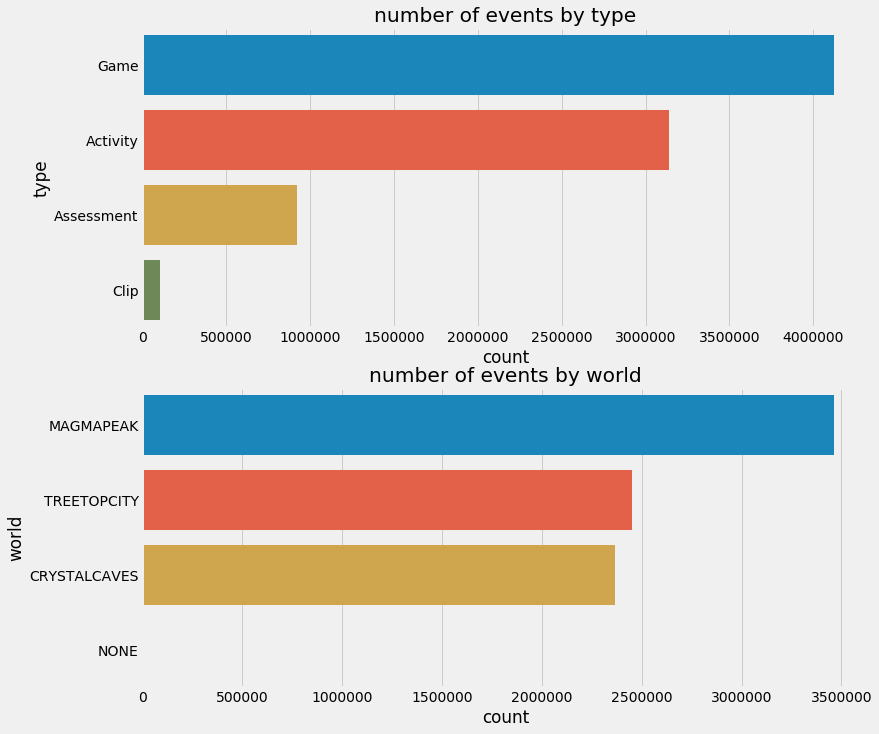

In [16]:
fig = plt.figure(figsize=(12, 10))

ax1 = fig.add_subplot(211)
ax1 = sns.countplot(y="type", data=train, order= train.type.value_counts().index)
plt.title("number of events by type")

ax2 = fig.add_subplot(212)
ax2 = sns.countplot(y="world", data=train, order = train.world.value_counts().index)
plt.title("number of events by world")
plt.tight_layout(pad=0)

Text(0.5, 1.0, 'Event counts by title')

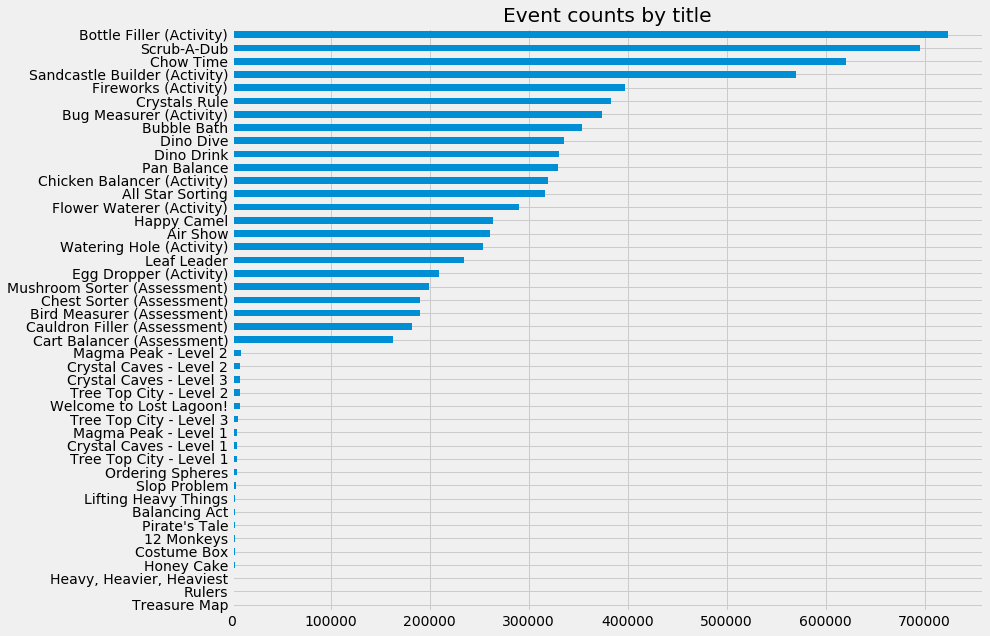

In [17]:
fig = plt.figure(figsize=(12,10))

title_count = train.title.value_counts().sort_values(ascending=True)
title_count.plot.barh()
plt.title("Event counts by title")

In [18]:
train['timestamp'] = pd.to_datetime(train['timestamp'])
train['date'] = train['timestamp'].dt.date
train['month'] = train['timestamp'].dt.month
train['hour'] = train['timestamp'].dt.hour
train['dayofweek'] = train['timestamp'].dt.dayofweek

Text(0.5, 1.0, 'Event counts by date')

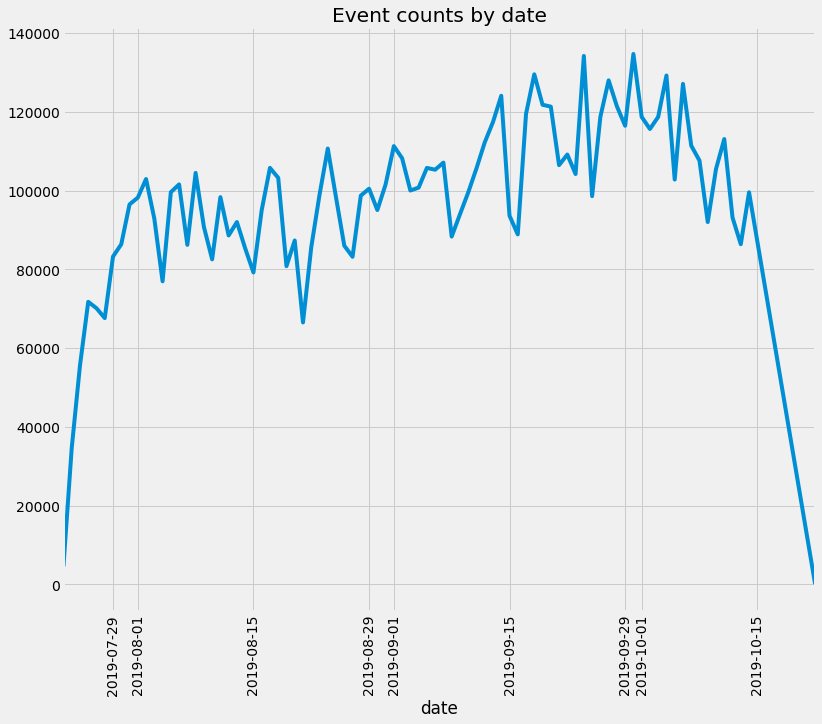

In [19]:
fig = plt.figure(figsize=(12,10))
date = train.groupby('date')['date'].count()
date.plot()
plt.xticks(rotation=90)
plt.title("Event counts by date")

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

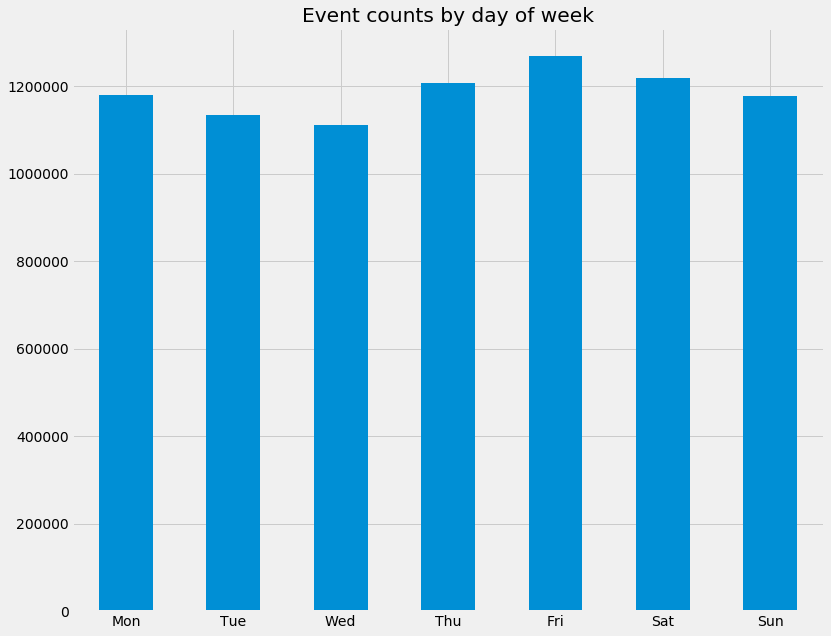

In [20]:
fig = plt.figure(figsize=(12,10))
day_of_week = train.groupby('dayofweek')['dayofweek'].count()
# convert num -> category
day_of_week.index = list(calendar.day_abbr)
day_of_week.plot.bar()
plt.title("Event counts by day of week")
plt.xticks(rotation=0)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 <a list of 24 Text xticklabel objects>)

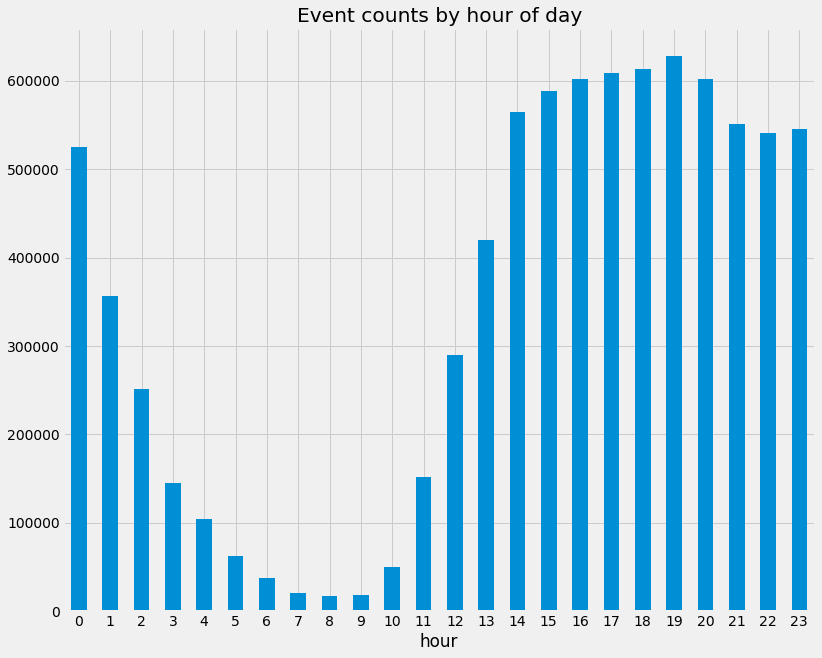

In [21]:
fig = plt.figure(figsize=(12,10))
hour = train.groupby('hour')['hour'].count()
hour.plot.bar()
plt.title("Event counts by hour of day")
plt.xticks(rotation=0)

In [22]:
test.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES


In [23]:
test.shape

(1156414, 11)

In [24]:
test.installation_id.nunique()

1000

There are no installation_ids without assessment in the test set

In [25]:
sample_submission.shape

(1000, 2)

Check if there is any overlap with regards to installation_id's in the train and test set

In [26]:
set(list(train.installation_id.unique())).intersection(list(test.installation_id.unique()))

set()

There are no installation_id's that appear in both train and test

In [27]:
test['timestamp'] = pd.to_datetime(test['timestamp'])

print(f'The range of date in train is: {train.date.min()} to {train.date.max()}')
print(f'The range of date in test is: {test.timestamp.dt.date.min()} to {test.timestamp.dt.date.max()}')

The range of date in train is: 2019-07-23 to 2019-10-22
The range of date in test is: 2019-07-24 to 2019-10-14


train_labels dataset

In [28]:
train_labels.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


In [29]:
train_labels.shape

(17690, 7)

In [30]:
pd.crosstab(train_labels.title, train_labels.accuracy_group)

accuracy_group,0,1,2,3
title,,,,
Bird Measurer (Assessment),886,778,389,693
Cart Balancer (Assessment),576,353,470,2752
Cauldron Filler (Assessment),421,459,630,2545
Chest Sorter (Assessment),1752,466,256,507
Mushroom Sorter (Assessment),594,355,460,2348


accuracy_group =>
* 0: the assessment was never solved
* 1: the assessment was solved after 3 or more attempts
* 2: the assessment was solved on the second attempt
* 3: the assessment was solved on the first attempt

Text(0.5, 1.0, 'Counts of titles')

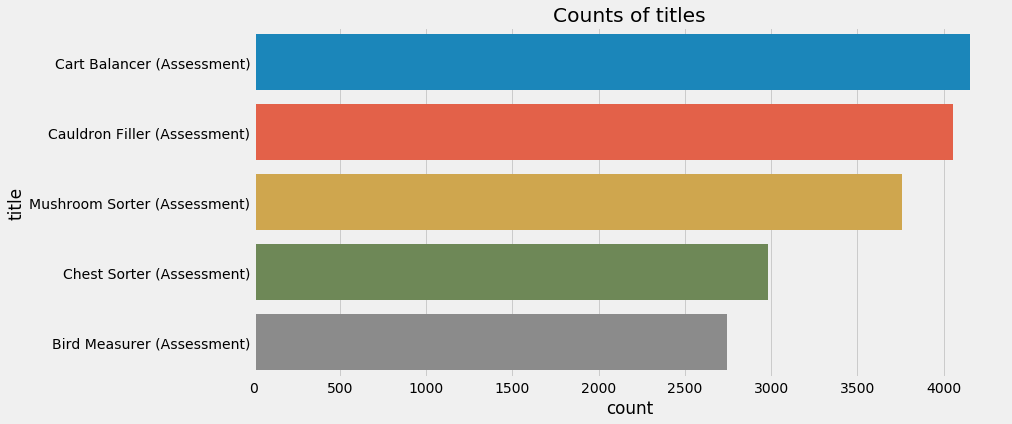

In [31]:
plt.figure(figsize=(12,6))
sns.countplot(y="title", data=train_labels, order = train_labels.title.value_counts().index)
plt.title("Counts of titles")

In [58]:
df = train_labels.groupby(['accuracy_group', 'title'])['accuracy_group']
df.count()

accuracy_group  title                       
0               Bird Measurer (Assessment)       886
                Cart Balancer (Assessment)       576
                Cauldron Filler (Assessment)     421
                Chest Sorter (Assessment)       1752
                Mushroom Sorter (Assessment)     594
1               Bird Measurer (Assessment)       778
                Cart Balancer (Assessment)       353
                Cauldron Filler (Assessment)     459
                Chest Sorter (Assessment)        466
                Mushroom Sorter (Assessment)     355
2               Bird Measurer (Assessment)       389
                Cart Balancer (Assessment)       470
                Cauldron Filler (Assessment)     630
                Chest Sorter (Assessment)        256
                Mushroom Sorter (Assessment)     460
3               Bird Measurer (Assessment)       693
                Cart Balancer (Assessment)      2752
                Cauldron Filler (Assessment)    2545
 

Text(0.5, 1.0, 'Counts of accuracy group')

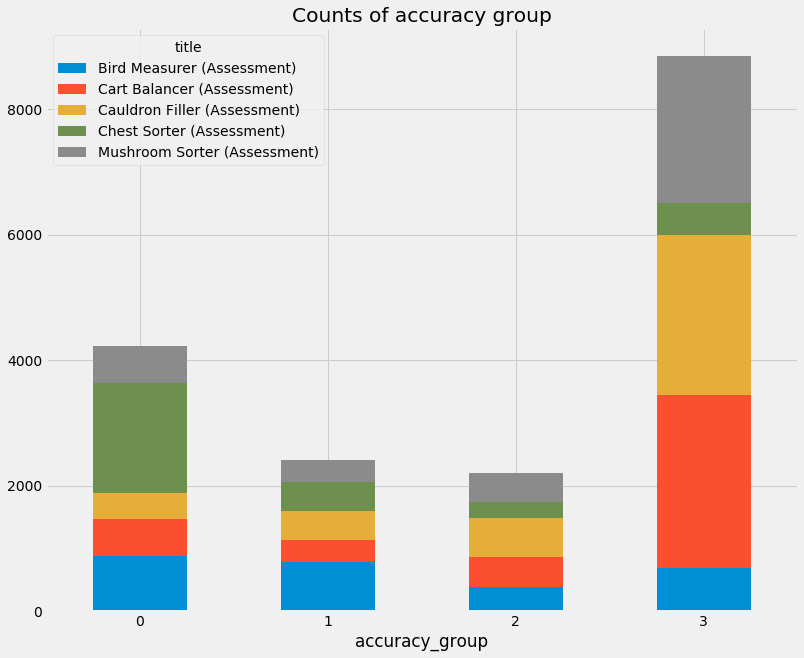

In [54]:
se = train_labels.groupby(['title', 'accuracy_group'])['accuracy_group'].count().unstack('title')
se.plot.bar(stacked=True, rot=0, figsize=(12,10))
plt.title("Counts of accuracy group")

installation_id's who did assessments but without results in the train_labels (we have already taken out the ones who never took one)

In [33]:
train[~train.installation_id.isin(train_labels.installation_id.unique())].installation_id.nunique()

628

Cannot train on installation_id's anyway, so taking them out of the train set. This reduces train set from 8.3 million rows to 7.7 million.

In [34]:
train = train[train.installation_id.isin(train_labels.installation_id.unique())]
train.shape

(7734558, 15)

Feature engineering

In [60]:
print(f'No. of rows in train_labels: {train_labels.shape[0]}')
print(f'Number of unique game_sessions in train_labels: {train_labels.game_session.nunique()}')

No. of rows in train_labels: 17690
Number of unique game_sessions in train_labels: 17690


In [61]:
train = train.drop(['date', 'month', 'hour', 'dayofweek'], axis=1)

In [ ]:
def encode_title(train, test, train_labels):
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    
    all_title_event_code = list(set(train['title_event_code'].unique()).union(test['title_event_code'].unique()))
    
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    
    activities_map = dict(zip(list_of_user_activities, np,arange(len(list_of_user_activities))))
    
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    
    # replace title with its number from the dictionary
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    
    train_labels['title'] = train_labels['title'].map(activities_map)
    
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    return train, test, train_labels, all_title_event_code, list_of_user_activities, list_of_event_code, list_of_event_id, activities_labels, assess_titles
    

In [ ]:
train, test, train_labels, all_title_event_code, list_of_user_activities, list_of_event_code, list_of_event_id, activities_labels, assess_titles = encode_title(train, test, train_labels)